In [1]:
%load_ext autoreload
%autoreload 2


In [2]:

import sys
sys.path.append('/Users/michaelkatz/Research/Eryn/')

from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import PriorContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove
from eryn.utils.utility import groups_from_inds

import matplotlib.pyplot as plt
import numpy as np

# set random seed
np.random.seed(42)

import corner


In [3]:
import eryn
eryn.__file__

'/Users/michaelkatz/anaconda3/envs/eryn_env/lib/python3.9/site-packages/eryn/__init__.py'

# Eryn

Eryn is an advanced MCMC sampler. It has the capability to run with parallel tempering, multiple model types, and unknown counts within each model type using Reversible-Jump MCMC techniques. Eryn is heavily based on [emcee](https://emcee.readthedocs.io/en/stable/). The `emcee` base structure with the Ensemble Sampler, State objects, proposal setup, and storage backends is carried over into Eryn with small changes to account for the increased complexity. In a simple sense, Eryn is an advanced (and slightly more complicated) version of `emcee`. 

In this tutorial, we will go through much of what is available in Eryn. We will start with a basic sampling operation to illustrate how to build and navigate common objects in Eryn. We will then scale up the complexity to understand how to use Eryn in different circumstances. 

If you use Eryn in your publication, please cite (# TODO: add paper). The documentation for Eryn can be found here: (# TODO: add website). You will find the code on Github: [github.com/mikekatz04/Eryn](https://github.com/mikekatz04/Eryn). (# TODO: add zenodo as well)

## The Tree Metaphor

Before we get into using the sampler, we will discuss the "infamous" tree metaphor. It helped in thinking about the early creation of Eryn and has carried through to the end. `Eryn` is the Sindarin word for "forest" or "woods." The purpose of this metaphor is to simplify the complex dimensionality associated with changing models and model counts in MCMC. We choose not to use "model" and "model counts" everywhere because those descriptions can quickly become confusing. 

We start with a forest with a bunch of trees. These trees are the MCMC "walkers". Each tree will have the same number of branches which is fixed throughout a sampling run (i.e. each walker has the same base setup). These branches are our different model types. For example, if you have a signal that is a combination of sine waves and Gaussians. In this case, you have two branches, one for the "sine wave" model and one for the "Gaussian" model. The number of Gaussians or sine waves is accounted for as the number of "leafs" on each branch. So, if 1 walker has 3 Gaussians and 2 sine waves, we can imagine this as a tree with two branches. The first branch for sine waves has 2 leaves and the second branch as 3 leaves for 3 Gaussians. 

When we get to parallel tempering, you can imagine different forests at different temperatures, all having the same number of trees (walkers). 

(# TODO: add image)

## Getting Started with the Ensemble Sampler

Let's start by running on a simple multivariate Gaussian likelihood:
$$\ln{\mathcal{L}}\propto -\frac{1}{2}(\vec{x} - \vec{\mu})^T \tilde{C}^{-1} (\vec{x} - \vec{\mu})$$

In [4]:
# Gaussian likelihood
def log_like_fn(x, mu, invcov):
    diff = x - mu
    return -0.5 * (diff * np.dot(invcov, diff.T).T).sum()


Add the initial settings: number of dimensions and number of walkers. Then, generate a covariance matrix for the given dimensionality for the likelihood and a set of means for each component of the Gaussian.

In [5]:
ndim = 5
nwalkers = 100

# mean
means = np.zeros(ndim)  # np.random.rand(ndim)

# define covariance matrix
cov = np.diag(np.ones(ndim))
invcov = np.linalg.inv(cov)

Next we will build our priors. For simplicity (and based on this problem), we will use a hyper-cube centered on the means with side length set to be `2 * lims`. Eryn requires a class object as the prior with an `logpdf` method (similar to `scipy.stats` distributions). Eryn provides a helper class to aid in this process: [`eryn.prior.PriorContainer`](https://mikekatz04.github.io/Eryn/build/html/user/prior.html#prior-container). This class takes a dictionary as input. In the simplest form, the keys are integers representing the index into the array of parameters and the values are the associated distributions: `{index: distribution}`. Eryn has a wrapper for the `scipy.stats.uniform` class that allows you to enter the start and stop points: [`eryn.prior.uniform`](https://mikekatz04.github.io/Eryn/build/html/user/prior.html#eryn.prior.uniform_dist). For example, if we have a 3D space with uniform priors for all dimensions from -1 to 1, the input dictionary would look like this:
```
priors_in = {
    0: uniform_dist(-1, 1),
    1: uniform_dist(-1, 1),
    2: uniform_dist(-1, 1)
}
```

In [6]:
# set prior limits
lims = 5.0
priors_in = {i: uniform_dist(-lims + means[i], lims + means[i]) for i in range(ndim)}
priors = PriorContainer(priors_in)


In this case, we are not going to use really any of Eryn's special capabilities. This will allow us to focus on how to navigate the sampler and deal with its output. Then we can add the fun stuff!

The object that directs everything in Eryn (like in `emcee`) is [`eryn.ensemble.EnsembleSampler`](https://mikekatz04.github.io/Eryn/build/html/user/ensemble.html#eryn.ensemble.EnsembleSampler). It required arguments are number of walkers, dimensionality of inputs (for this simple case this is an integer), the log likelihood function, and the priors. Similar to `emcee`, you can add arguments and keyword arguments to the Likelihood function by providing the `args` and `kwargs` keyword arguments to the `EnsembleSampler`. In this case, we add the means and inverse of the covariance matrix as extra arguments.

In [7]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_like_fn,
    priors,
    args=[means, invcov],
)

Now we will get starting positions for our walkers by sampling from the priors using the `rvs` method of the `PriorContainer` and then evaluating the associated Likelihood and prior values. The `rvs` method is also called like in `scipy.stats` distributions.

In [8]:
# starting positions
# randomize throughout prior
coords = priors.rvs(size=(nwalkers,))

# check log_like
log_like = np.asarray([
    log_like_fn(coords[i], means, invcov)
for i in range(nwalkers)])
print(log_like)

# check log_prior
log_prior = np.asarray([
    priors.logpdf(coords[i])
for i in range(nwalkers)])
print(log_prior)


[-30.69858605 -27.88613553 -10.22294092 -14.70569247 -18.96300942
 -40.24777582 -18.73441074 -24.83741982 -29.01040764 -27.8427905
 -15.6395355  -37.63324244 -37.32945619 -23.65755241 -14.71578138
 -17.41587351 -10.60372232 -14.78508305 -16.44610878 -14.65807937
 -10.96569731 -21.07245692 -21.71012131 -11.7938995  -26.68678623
 -10.56139796 -21.07206293 -15.22766639 -21.70138195 -21.66486977
 -12.67496753 -16.03289018 -29.46929288 -26.72131899 -44.24698912
 -21.3584848  -19.77366496 -28.72150734  -5.84518648 -33.37118884
 -36.15731891 -25.26041351 -25.57594664 -12.25802303 -22.37039294
 -31.88982593 -15.35309536 -24.45627855 -22.46651653 -23.11210745
 -25.31311317 -14.36123373 -23.67409531 -23.41272599 -34.51272062
 -13.40386882 -42.6083427  -10.3819265  -33.56151466 -19.79275524
 -10.09464227 -17.63670509 -15.88594767  -1.5583328  -38.33786195
 -10.04251137 -22.92432228 -26.5383962  -29.02898281 -34.39747766
 -29.93610511 -43.67631032 -37.6288042  -26.57863213 -12.43201382
 -21.713395

Because we are in the unit cube, the prior values are constant. 

Now, we can run the sampler using the `run_mcmc` method on the `EnsembleSampler` class. It first takes as an argument an array of the starting positions (or a `State` object which we will cover below). We also must provide the number of steps as the second argument. Helpful kwargs (not all inclusive):

* `burn`: Perform a burn in for a certain number of proposals.
* `progress`: If `True`, show the progress as the sampler runs.
* `thin_by`: How much to thin the chain directly before storage.

The total number of proposals the sampler will do is `nsteps * thin_by`. It will store `nsteps` samples.

In [13]:
nsteps = 50
# burn for 1000 steps
burn = 10
# thin by 5
thin_by = 5
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

100%|████████████████████████████████████████| 250/250 [00:01<00:00, 237.86it/s]


Similar to `emcee`, all of the sampler information is stored in a backend object. In the default case, this backend is [`eryn.backends.Backend`](https://mikekatz04.github.io/Eryn/build/html/user/backend.html#eryn.backends.Backend). To retrieve the samples from the backend, you call the `get_chain` method. This will return a dictionary with keys at the omdel names and a 5-dimensional array per model, which can be intimidating. We will cover that array just below. For now, just focus on the output of the sampler. 

We will first generate corner plot. In this initial example, we have not defined branch names, therefore, the sampler has assigned our problem default branch names `model_0`,...,`model_n`.

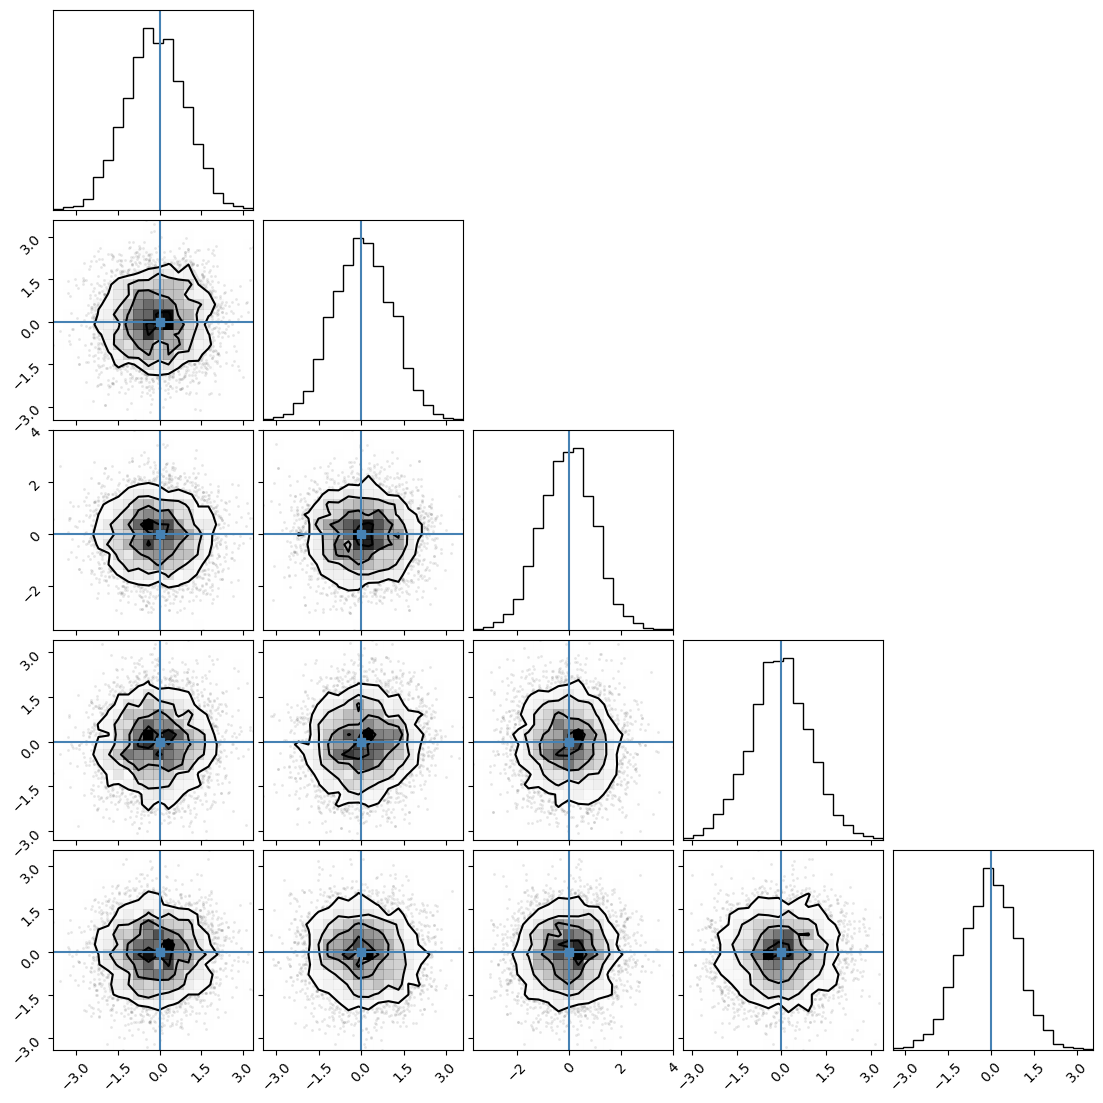

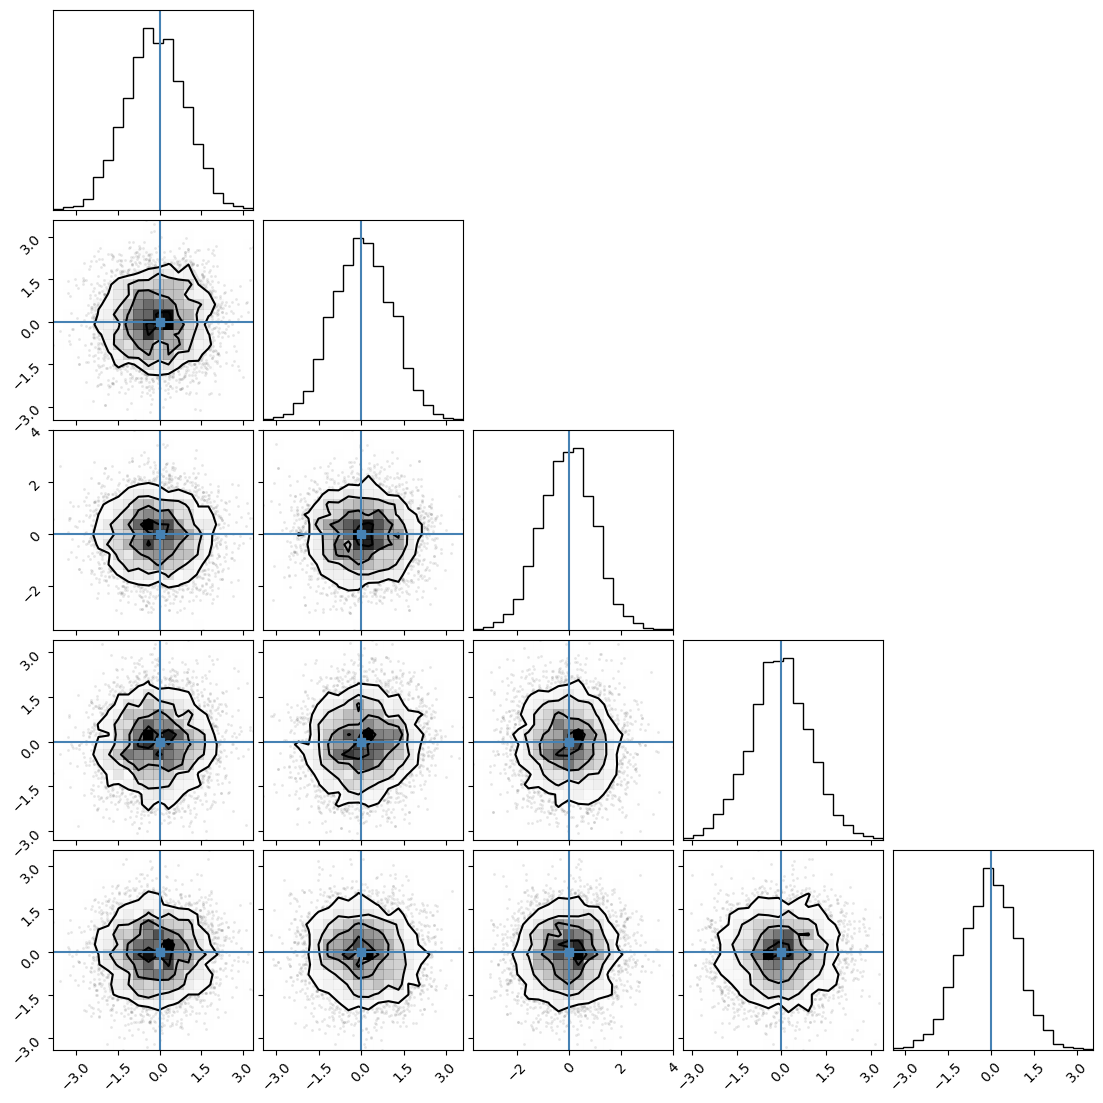

In [16]:
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner.corner(samples, truths=means)

Now we will plot the chains.

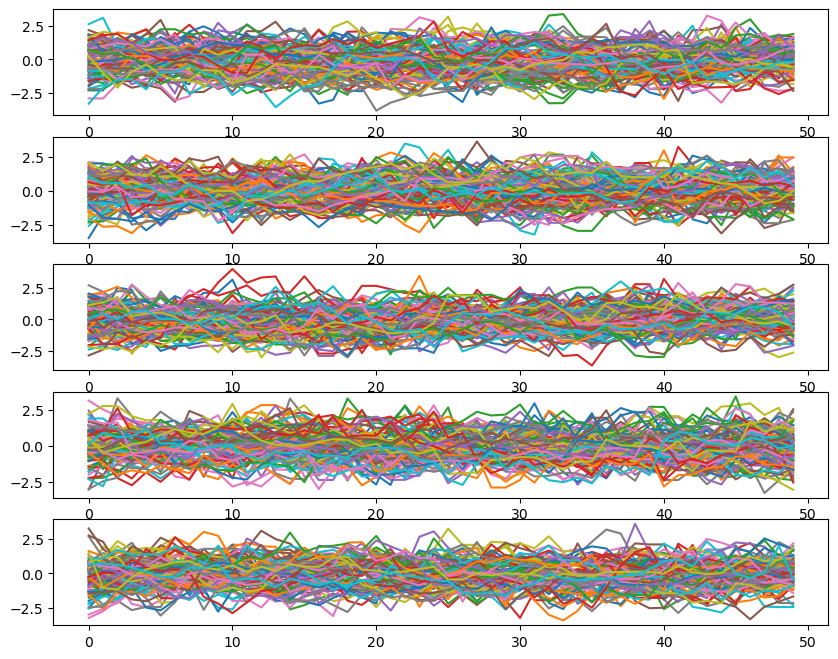

In [17]:
#### Chains
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i])

## Backend Objects

Backends are where all of the information in the sampler is stored as it runs. It is from these backends that samples are retrieved for plotting. You can find the documentation for the Backend objects [here](https://mikekatz04.github.io/Eryn/html/user/backend.html#backends). Here, we will go through the most commonly used functions from the backend:
* `get_chain`: retrieve all of the samples stored over the course of the sampling run.
* `get_log_like`: retrieve the log of the Likelihood for each sample.
* `get_log_prior`: retrieve the log of the prior for each sample.
* `get_a_sample`: retrieve a state object from a specific iteration. `get_last_sample` may be more common. It is just a specific example of `get_a_sample` for the last sample.

Many (but not all) of the methods from the backend object are also raised to the level of sampler. So you can either call `EnsembleSampler.backend.method` or `EnsembleSampler.method` and it will be equivalent.

Common properties to get from the backend:
* `shape`: returns a dictionary with keys for each branch name and values as tuples representing the specific shape for each model (this shape will not include the `nsteps` outer dimension.
* `iteration`: number of stored iterations in the backend.

Now we will get the likelihood and prior. Notice the shape of the Likelihood is `(nsteps, ntemps, nwalkers)` (in this example we have 1 temperature). This will always be the shape of quantities that are a single value per walker (e.g. Likelihood, prior, posterior).

In [26]:
ll = ensemble.backend.get_log_like()
lp = ensemble.backend.get_log_prior()

print(f"Number of iterations {ensemble.backend.iteration}")
# equivalent to ensemble.get_log_like() and ensemble.get_log_prior()
print(ll.shape, ll, lp)

Number of iterations 50
(50, 1, 100) [[[-9.43378049 -1.02493852 -4.17726471 ... -5.41402824 -4.02673368
   -6.18991868]]

 [[-4.52526005 -1.62876958 -1.66639971 ... -5.29449201 -3.19307031
   -3.09561382]]

 [[-2.47959226 -4.13212497 -3.8753185  ... -2.76500856 -6.39228333
   -1.7003192 ]]

 ...

 [[-1.71557368 -1.9977553  -2.84171927 ... -1.4080743  -1.53589636
   -1.1843373 ]]

 [[-1.16305075 -6.99215316 -1.59208011 ... -3.08587029 -1.62457723
   -3.25310739]]

 [[-3.18607669 -1.1429558  -1.6589886  ... -1.47512843 -2.64662908
   -0.39670766]]] [[[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 ...

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -11.51292546]]

 [[-11.51292546 -11.51292546 -11.51292546 ... -11.51292546 -11.51292546
   -1

### 5-dimensional Arrays

The chain information is returned as a dictionary with keys as the branch names and values as 5-dimensional arrays: `(nsteps, ntemps, nwalkers, nleaves_max, ndim)`. For clarity:
* nsteps: number of sampler iterations stored (time evolution of each forest)
* ntemps: number of temperatures (which forest you are in)
* nwalkers: number of walkers (which tree)
* nleaves_max: maximum number of model counts or leaves for each specific branch.
* ndim: number of parameters describing a single model or leaf.

In our simple example, we have 1 temperature and our maximum leaf count is 1.

In [34]:
# getting the chain
samples = ensemble.get_chain()

# same as 
# samples = enseble.backend.get_chain()
print(type(samples), samples.keys(), samples["model_0"].shape)

<class 'dict'> dict_keys(['model_0']) (50, 1, 100, 1, 5)


We can also get the shape information direct from the backend:

In [35]:
ensemble.backend.shape

{'model_0': (1, 100, 1, 5)}

## State Objects

Now, we are going to look at [`State`](https://mikekatz04.github.io/Eryn/build/html/user/state.html#eryn.state.State) objects. They carry the current information throughout the sampler about the current state of the sampler. In our simple example, we can examine the current coordinates, likelihood, and prior values. 

Output from the sampler above is the last state of the sampler `out`. This will include any additional objects passed through the sampler like `BranchSupplimental` objects that we will explain below. 

Another way to retrieve the last state is from the backend. That is what we will do here. However, please note, that supplimental information (discussed below) is not stored in the backend, so the state that is returned from the backend will have information that is stored in the backend, but not supplimental information that was passed through the sampler at runtime. 

In [30]:
last_state = ensemble.backend.get_last_sample()
print(type(last_state))

<class 'eryn.state.State'>


We can access the Likelihood and prior values as `State.log_like` and `State.log_prior`. We can also ask the state to give use the posterior probability with the `get_log_prob` method. Note that shape of these values is `(ntemps, nwalkers)`. This is because `State` objects represent one moment in time in the sample, so they do not have the `nsteps` outer dimension that the backend has. 

In [31]:
print(out.log_like.shape, out.log_like, out.log_prior, out.get_log_prob())

(1, 100) [[-3.18607669 -1.1429558  -1.6589886  -1.60856068 -2.05237241 -2.80511361
  -3.2820529  -0.48777215 -4.69744231 -4.54166543 -0.49613285 -2.57913187
  -0.82081494 -3.15835422 -4.69374692 -1.36431241 -1.02297895 -3.81079257
  -1.3500181  -2.69702179 -0.94306879 -0.68869336 -1.55075872 -1.77505016
  -1.29913963 -0.47419261 -4.0502107  -4.29488605 -5.78437773 -5.5541193
  -1.66435034 -5.32560629 -4.35274089 -4.13308071 -0.75070212 -0.51465938
  -1.96452927 -2.96740213 -5.80681138 -4.45549403 -2.34328003 -1.40855724
  -1.85349052 -0.6874936  -1.03817694 -1.38031118 -4.25650003 -3.3810526
  -2.91694682 -1.83256203 -2.18093864 -4.73560743 -1.46391034 -2.48634414
  -3.10277004 -4.19744949 -1.45608498 -2.77594935 -1.79394206 -2.81752866
  -2.98090146 -3.03810478 -1.99565952 -0.66910034 -1.13193638 -1.67270637
  -2.18410851 -0.32066335 -1.41987524 -1.47641726 -0.84826231 -1.45503317
  -1.15618694 -3.20802127 -1.0925304  -2.32264582 -4.37653078 -0.70767912
  -2.06409617 -1.07758357 -2.10

### Branches

`State` objects store quantities at are single values per walker directly in the state as shown above (e.g. `State.log_like`). Information that gets down to the individual branch (or model type) level is stored in a [`Branch`](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.Branch) object. These `Branch` objects are stored in a dictionary within the `State` object with keys as branch names and values as the `Branch` object associated with that branch name. The branch objects can be accessed as `state.branches[model_name]`. With in the branch object, the coordinates are stored. A few other things are stored, but we will get to that later. If you want a dictionary with keys at the branch names and values as the current coordinates, you can also use the property: `state.branches_coords`.

In [32]:
last_state.branches

{'model_0': <eryn.state.Branch at 0x170ece4c0>}

In [33]:
last_state.branches["model_0"].coords

# same as 
# last_state.branches_coords["model_0"]

array([[[[-1.42033703e+00, -1.02810079e-01, -8.59592624e-01,
           1.82272349e+00, -5.31982881e-01]],

        [[-1.94132413e-01,  1.14762173e+00,  4.05768945e-01,
           3.61701175e-01,  7.97315756e-01]],

        [[ 1.43261582e-01, -9.86631926e-01,  2.11648516e-01,
          -1.27932905e+00,  8.01581470e-01]],

        [[ 2.01818181e-01, -1.59802298e+00,  1.55396702e-01,
           7.13028032e-01, -3.00260264e-01]],

        [[ 1.44705546e+00, -1.13931177e+00, -7.48192220e-01,
          -3.45896320e-01,  1.82505165e-01]],

        [[-3.27195605e-01, -4.87979115e-01,  1.01553382e+00,
          -2.05713856e+00,  4.38021849e-02]],

        [[-2.26384056e+00,  5.77714736e-01,  7.65492139e-01,
          -7.20306761e-01,  2.36085913e-02]],

        [[ 6.22784602e-01,  2.28081336e-01,  3.35603738e-01,
           3.17484741e-01,  5.67658450e-01]],

        [[-1.81767283e+00,  1.34148567e+00, -1.28988890e+00,
           1.21797001e+00, -1.06962704e+00]],

        [[ 1.21532719e-01,  

## Parallel Tempering

Adding tempering to our problem is straight forward. It will effectively just take the `ntemps` dimension that was 1 above and stretch it to the number of temperatures desired. We add tempering information by providing the `tempering_kwargs` argument to the `EnsembleSampler`. The tempering kwargs documentation can be found here: `eryn.moves.tempering.TemperatureControl` 

In [ ]:

ndim = 5
nwalkers = 100
ntemps = 10

tempering_kwargs=dict(ntemps=ntemps)

# randomize throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))

ensemble_pt = EnsembleSampler(
    nwalkers,
    ndim,
    log_prob_fn,
    priors,
    args=[means, cov],
    tempering_kwargs=tempering_kwargs
)

nsteps = 5000
# burn for 1000 steps
burn = 1000
# thin by 5
thin_by = 5
ensemble_pt.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)



In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble_pt.get_chain()['model_0'][:, temp].reshape(-1, ndim)
    corner.corner(samples, truths=np.full(ndim, 0.0))

In [ ]:
#### Chains
for temp in range(ntemps):
    fig, ax = plt.subplots(ndim, 1)
    fig.set_size_inches(10, 8)
    for i in range(ndim):
        for walk in range(nwalkers):
            ax[i].plot(ensemble_pt.get_chain()['model_0'][:, temp, walk, :, i])

## Add multiple leaf count uncertainty (i.e. reversible-jump MCMC))

In [ ]:
# need new likelihood
def gaussian(x, a, b, c):
    f_x = a[:, None] * np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * c[:, None] ** 2))
    return f_x


def gaussian_flat(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x

def combine_gaussians(x1, group1, t):
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]

    gauss_out = gaussian(t, a, b, c)

    num_groups = group1.max() + 1

    # add templates to the proper template based on group1
    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    return template

def log_prob_fn(x1, group1, t, data, sigma):
    # x1 is one leaf's parameters
    # group1 is which tree this leaf belongs to

   
    template = combine_gaussians(x1, group1, t)

        
    ll = - 0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll


nwalkers = 20
ntemps = 4
ndims = [3]
nleaves_max = [8]

branch_names = ["gauss"]

# define time stream
num = 500
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [3.3, -0.2, 0.1],
    [2.6, -0.1, 0.1],
    [3.4, 0.0, 0.1],
    [2.9, 0.3, 0.1],
]

injection = np.zeros(num)

# combine gaussians
injection = combine_gaussians(np.asarray(gauss_inj_params), np.zeros(len(gauss_inj_params), dtype=int), t)[0]

# set noise level
sigma = 0.25
y = injection + sigma * np.random.randn(len(injection))

import matplotlib.pyplot as plt

plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.legend()

#### setup for reversible-jump

In [ ]:
# describes priors for all leaves independently
priors = {
    "gauss": {
        0: uniform_dist(2.5, 3.5),  # amplitude
        1: uniform_dist(t.min(), t.max()),  # mean 
        2: uniform_dist(0.01, 0.21),  # sigma
    },
}

coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.00000001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if nn >= len(gauss_inj_params):
            # fill a non-used starting leaf with reasonable parameters
            nn = np.random.randint(low=0, high=3)
        coords[name][:, :, nn] = np.random.multivariate_normal(gauss_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))  # dist.rvs(size=(ntemps, nwalkers, nleaf))

# make sure to start near the proper setup
inds = {
     name: np.zeros((ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['gauss'][:, :, :len(gauss_inj_params)] = True

coords_in = {name: coords[name][inds[name]] for name in coords}

# useful function: groups_from_inds
groups_in = groups_from_inds(inds)

log_prob = log_prob_fn(
    coords_in["gauss"],
    groups_in["gauss"],
    t,
    y,
    sigma
)

# make sure it is reasonably small
# will not be zero due to noise
log_prob = log_prob.reshape(ntemps, nwalkers)
print(log_prob)

# setup starting state

log_prob = log_prob.reshape(ntemps, nwalkers)

blobs = None  # np.random.randn(ntemps, nwalkers, 3)

state = State(coords, log_prob=log_prob, inds=inds)


In [ ]:
# for the Gaussian Move, will be explained later
factor = 0.0001
cov = {"gauss": np.diag(np.ones(ndims[0])) * factor}

moves = GaussianMove(cov)

# backend.grow(100, blobs)


ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)


In [ ]:
nsteps = 10000
ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)


In [ ]:
samples = ensemble.get_chain()['gauss'][:, 0].reshape(-1, ndim)
samples[~np.isnan(samples[:, 0])]

In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble.get_chain()['gauss'][:, temp].reshape(-1, ndim)
    
    # need to remove NaNs
    samples = samples[~np.isnan(samples[:, 0])]
    corner.corner(samples)

In [ ]:
print(f'max ll: {ensemble.get_log_prob().max()}')

bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 8)
for temp, ax_t in enumerate(ax):
    ax_t.hist(ensemble.get_nleaves()['gauss'][:, temp].flatten(), bins=bns)
    

## Add multiple branch

In [ ]:
# need new likelihood
def gaussian(x, a, b, c):
    f_x = a[:, None] * np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * c[:, None] ** 2))
    return f_x


def gaussian_flat(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x

def combine_gaussians(x1, group1, t):
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]

    gauss_out = gaussian(t, a, b, c)

    num_groups = group1.max() + 1

    # add templates to the proper template based on group1
    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    return template

# need new likelihood
def sine(x, a, b, c):
    f_x = a[:, None] * np.sin(2 * np.pi * b[:, None] * x + c[:, None])
    return f_x


def sine_flat(x, a, b, c):
    f_x = a * np.sin(2 * np.pi * b * x + c)
    return f_x

def combine_sines(x1, group1, t):
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]

    gauss_out = sine(t, a, b, c)

    num_groups = group1.max() + 1

    # add templates to the proper template based on group1
    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    return template

def log_prob_fn(xs, groups, t, data, sigma):
    # x1 is one leaf's parameters
    # group1 is which tree this leaf belongs to
    
    x1, x2 = xs
    group1, group2 = groups
    
    template_gaussian = combine_gaussians(x1, group1, t)
    
    template_sine = combine_sines(x2, group2, t)

    template = template_gaussian + template_sine
    
    ll = - 0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll


nwalkers = 20
ntemps = 4
ndims = [3, 3]
nleaves_max = [8, 5]

branch_names = ["gauss", "sine"]

# define time stream
num = 500
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [3.3, -0.2, 0.1],
    [2.6, -0.1, 0.1],
    [3.4, 0.0, 0.1],
    [2.9, 0.3, 0.1],
]

sine_inj_params = [
    [1.3, 10.1, 1.0],
    [0.8, 4.6, 1.2],
]

injection = np.zeros(num)

# combine gaussians
injection = combine_gaussians(np.asarray(gauss_inj_params), np.zeros(len(gauss_inj_params), dtype=int), t)[0]
injection += combine_sines(np.asarray(sine_inj_params), np.zeros(len(sine_inj_params), dtype=int), t)[0]
# set noise level
sigma = 0.5
y = injection + sigma * np.random.randn(len(injection))

import matplotlib.pyplot as plt

plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.legend()

#### setup for reversible-jump

In [ ]:
# describes priors for all leaves independently
priors = {
    "gauss": {
        0: uniform_dist(2.5, 3.5),  # amplitude
        1: uniform_dist(t.min(), t.max()),  # mean 
        2: uniform_dist(0.01, 0.21),  # sigma
    },
    "sine": {
        0: uniform_dist(0.5, 1.5),  # amplitude
        1: uniform_dist(1., 20.),  # mean 
        2: uniform_dist(0.0, 2 * np.pi),  # sigma
    },
}

coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.00000001
inj_params = {'gauss': gauss_inj_params, 'sine': sine_inj_params}
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if nn >= len(inj_params[name]):
            # fill a non-used starting leaf with reasonable parameters
            nn = np.random.randint(low=0, high=len(inj_params[name]))

        coords[name][:, :, nn] = np.random.multivariate_normal(inj_params[name][nn], np.diag(np.ones(ndim) * sig1), size=(ntemps, nwalkers))  # dist.rvs(size=(ntemps, nwalkers, nleaf))

# make sure to start near the proper setup
inds = {
     name: np.zeros((ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['gauss'][:, :, :len(gauss_inj_params)] = True
inds['sine'][:, :, :len(sine_inj_params)] = True

# setup groups just to compute likelihood
groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

log_prob = log_prob_fn(
    [coords_in["gauss"], coords_in["sine"]],
    [groups_in["gauss"], groups_in["sine"]],
    t,
    y,
    sigma
)

# make sure it is reasonably small
# will not be zero due to noise
log_prob = log_prob.reshape(ntemps, nwalkers)
print(log_prob)

# setup starting state

log_prob = log_prob.reshape(ntemps, nwalkers)

blobs = None  # np.random.randn(ntemps, nwalkers, 3)

state = State(coords, log_prob=log_prob, inds=inds)


In [ ]:
from eryn.moves.tempering import make_ladder

In [ ]:
help(make_ladder)

In [ ]:
# for the Gaussian Move, will be explained later
factor = 0.0001
cov = {"gauss": np.diag(np.ones(ndims[0])) * factor, "sine": np.diag(np.ones(ndims[0])) * factor}

moves = GaussianMove(cov)

total_ndim = sum([nleaves_max_i * ndim_i for nleaves_max_i, ndim_i in zip(nleaves_max, ndims)])
betas = make_ladder(total_ndim, ntemps=ntemps)

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)


In [ ]:
nsteps = 10000
ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)


In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble.get_chain()['gauss'][:, temp].reshape(-1, ndim)
    
    # need to remove NaNs
    samples = samples[~np.isnan(samples[:, 0])]
    corner.corner(samples)

In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble.get_chain()['sine'][:, temp].reshape(-1, ndim)
    
    # need to remove NaNs
    samples = samples[~np.isnan(samples[:, 0])]
    corner.corner(samples)

In [ ]:
print(f'max ll: {ensemble.get_log_prob().max()}')

bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 8)
for temp, ax_t in enumerate(ax):
    ax_t.hist(ensemble.get_nleaves()['gauss'][:, temp].flatten(), bins=bns)
    

In [ ]:
print(f'max ll: {ensemble.get_log_prob().max()}')

bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 8)
for temp, ax_t in enumerate(ax):
    ax_t.hist(ensemble.get_nleaves()['sine'][:, temp].flatten(), bins=bns)
    

# Utilities

## Transform Container

Transform containers are primary used in likelihood functions to transform the arrays incoming from the sampler to the proper setup for likelihood computation. It can transform parameters based on transform functions and fill values into a final array for any value that is fixed during sampling. 

It can be passed to the likeihood function as an `arg` or `kwarg`.

In [ ]:
# can be done with lambda or regular function
# must have same number of inputs and outputs at same index in outer arrays
def transform1(x, y):
    return x * y, y / x

# this will do transform lambda x, y: (x**2, y**2) before transform1
parameter_transforms = {0: lambda x: np.log(x), (1, 2): lambda x, y: (x**2, y**2), (0, 2): transform1}

fill_dict = {
    "ndim_full": 6,  # full dimensionality after values are added
    "fill_inds": np.array([2, 3, 5]),  # indexes for fill values in final array
    "fill_values": np.array([0.0, 1.0, -1.0]),  # associated values for filling
}

tc = TransformContainer(parameter_transforms=parameter_transforms, fill_dict=fill_dict)

x = np.random.uniform(0.1, 4.0, size=(40, 3))

# can copy and transpose values if needed
out = tc.transform_base_parameters(x, copy=True, return_transpose=False)
print(out)

If you have mutliple branches in your sampler, you can add more than one `Transform Container`. 

In [ ]:
def lnprob(x1, group1, x2, group2, transform_containers):
    x = [x1, x2]
    for i, (x_i, transform) in enumerate(zip([x1, x2], transform_containers)):
        temp = transform.transform_base_parameters(x_i, copy=True, return_transpose=False)
        x[i] = transform.fill_values(temp)
        
    print(x)
    
    ## do more in the likelihood here with transformed information
    
# setup transforms for x1
parameter_transforms1 = {0: lambda x: np.log(x)}

# setup transforms for x2 
parameter_transforms2 = {(1, 2): lambda x, y: (x**2, y**2)}

# fill dict for x1
fill_dict1 = {
    "ndim_full": 6,  # full dimensionality after values are added
    "fill_inds": np.array([2, 3, 5]),  # indexes for fill values in final array
    "fill_values": np.array([0.0, 1.0, -1.0]),  # associated values for filling
}

# fill dict for x2
fill_dict2 = {
    "ndim_full": 5,  # full dimensionality after values are added
    "fill_inds": np.array([1]),  # indexes for fill values in final array
    "fill_values": np.array([-1.0]),  # associated values for filling
}

tcs = [
    TransformContainer(parameter_transforms=parameter_transforms1, fill_dict=fill_dict1), 
    TransformContainer(parameter_transforms=parameter_transforms2, fill_dict=fill_dict2),
]

num = 40
x1 = np.random.uniform(0.1, 4.0, size=(num, 3))
x2 = np.random.uniform(0.1, 4.0, size=(num, 4))

group1 = np.arange(num)
group2 = np.arange(num)

# it can be added via args or kwargs in the ensemble sampler
lnprob(x1, group1, x2, group2, tcs)
